# Conditional latent diffusion model for image inpainting

In [1]:

## Import libraries
# system
import os
import time
import sys
import argparse
from pathlib import Path
import json
import random

# machine learning
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torchvision.utils
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import random_split
from torchsummary import summary

#diffusers
from diffusers import (
    StableDiffusionControlNetInpaintPipeline,
    ControlNetModel,
    DDIMScheduler,
    UNet2DConditionModel,
)
from transformers import CLIPTokenizer

# data manipulation
import math
from PIL import Image
import yaml
import xarray as xr
import dask
import numpy as np
# dask friendliness for large rasters
dask.config.set({"array.slicing.split_large_chunks": True})

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

###### setup config variables #######
repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

# Import helper functions
sys.path.append(f"{repo_dir}/code/helpers")
from get_region_filenames import get_region_filenames

with open(f"{repo_dir}/config.yml", 'r') as stream:
    config = yaml.safe_load(stream)

regions = config['regions'] 

big_data_storage_path = config.get("big_data_storage_path", "/work/zt75vipu-master/data")
region_filenames_json = get_region_filenames(config_path=f"{repo_dir}/config.yml")
print("Region filenames JSON loaded successfully: ", region_filenames_json)

#seaborn cmap
rocket=sns.color_palette("rocket", as_cmap=True)
mako=sns.color_palette("mako", as_cmap=True)


Getting region filenames from config...
Regions to process: ['Dresden', 'Leipzig', 'Hamburg', 'Stuttgart']
Region filenames JSON loaded successfully:  {'Dresden': {'landsat_zarr_name': 'D:/master_thesis/data/landsat/dresden/landsat_temperature_ge25_cc10_2019_2024.zarr', 'osm_zarr_name': 'D:/master_thesis/data/osm/dresden/osm_rasterized.zarr', 'planet_zarr_name': 'D:/master_thesis/data/planet_scope/dresden/planet_config_ge25_cc10_2019_2024.zarr', 'processed_zarr_name': 'D:/master_thesis/data/processed/dresden/input_config_ge25_cc10_2019_2024.zarr'}, 'Leipzig': {'landsat_zarr_name': 'D:/master_thesis/data/landsat/leipzig/landsat_temperature_ge25_cc10_2019_2024.zarr', 'osm_zarr_name': 'D:/master_thesis/data/osm/leipzig/osm_rasterized.zarr', 'planet_zarr_name': 'D:/master_thesis/data/planet_scope/leipzig/planet_config_ge25_cc10_2019_2024.zarr', 'processed_zarr_name': 'D:/master_thesis/data/processed/leipzig/input_config_ge25_cc10_2019_2024.zarr'}, 'Hamburg': {'landsat_zarr_name': 'D:/maste

In [2]:
from dataset.dataset import UrbanInpaintingDataset

Loading zarr dataset from D:/master_thesis/data/processed/leipzig\input_config_ge25_cc10_2019_2024_clipped.zarr...
Using date: 2022-08-03T10:03:00.000000000
Found 1883 valid patches for split train
Image shape: torch.Size([4, 3, 216, 216])
Conditioning keys: dict_keys(['masked_image', 'mask', 'osm_features', 'environmental'])
Masked image shape: torch.Size([4, 3, 216, 216])
OSM features shape: torch.Size([4, 3, 216, 216])


tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1.,  1.,  ..., -1., -1., -1.],
          [-1., -1.,  1.,  ..., -1., -1., -1.]],

         [[ 1.,  1.,  1.,  ..., -1., -1., -1.],
          [ 1.,  1.,  1.,  ..., -1., -1., -1.],
          [ 1.,  1.,  1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1.,  1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]],

         [[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ...,  1.,  1.,  1.],
          [-1., -1., -1.,  ...,  1.

Environmental shape: torch.Size([4, 2, 216, 216])


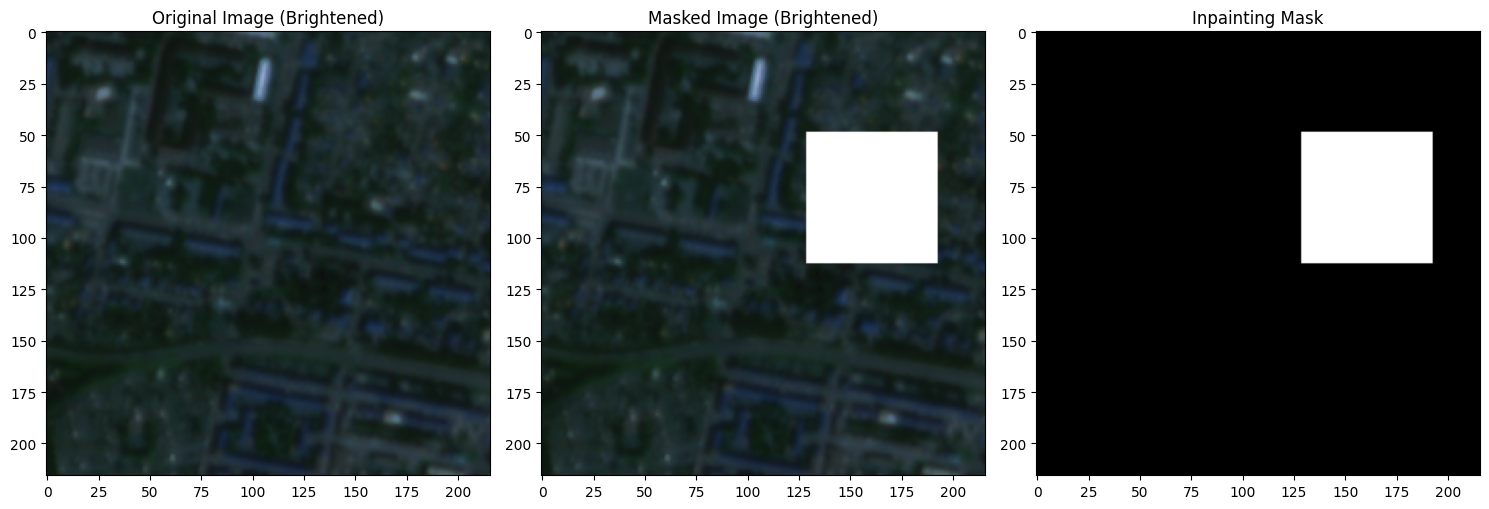

In [ ]:
def collate_fn(batch):
    """
    Custom collate function to handle batches with conditioning dictionaries
    """
    if isinstance(batch[0], tuple):
        # Unpack images and conditioning dicts
        images = torch.stack([item[0] for item in batch])
        
        # Collate conditioning inputs
        cond_inputs = {}
        sample_cond = batch[0][1]
        
        for key in sample_cond.keys():
            cond_inputs[key] = torch.stack([item[1][key] for item in batch])
        
        return images, cond_inputs
    else:
        # Just images, no conditioning
        return torch.stack(batch)


def train():
    # Create dataset instance
    train_dataset = UrbanInpaintingDataset(
        split='train',
        use_latents=False,
        latent_path=None
    )

    # Set random seed
    torch.manual_seed(42)

    # Create dataloader
    train_loader = DataLoader(
        train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0, # on windows set to 0 to avoid conflicts
        collate_fn=collate_fn
    )
    
    # Iterate through the dataset
    for batch in train_loader:
        if isinstance(batch, tuple):
            # With conditioning
            images, cond_inputs = batch
            print(f"Image shape: {images.shape}")
            print(f"Conditioning keys: {cond_inputs.keys()}")
            
            # Access specific conditioning inputs
            if 'masked_image' in cond_inputs:
                print(f"Masked image shape: {cond_inputs['masked_image'].shape}")
            if 'osm_features' in cond_inputs:
                print(f"OSM features shape: {cond_inputs['osm_features'].shape}")
                # display(cond_inputs['osm_features'])
            if 'environmental' in cond_inputs:
                print(f"Environmental shape: {cond_inputs['environmental'].shape}")
        else:
            # Without conditioning
            images = batch
            print(f"Image shape: {images.shape}")
        
        break  # Just show first batch
    
    # Visualize a sample
    sample_idx = 405
    if len(train_dataset.condition_types) > 0:
        img, cond = train_dataset[sample_idx]
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        # Original image (denormalize from [-1,1] to [0,1])
        img_vis = (img + 1) / 2.0
        # Apply brightness adjustment for better visualization
        img_vis = torch.clamp(img_vis * 2.5, 0, 1)  # Multiply by 2.5 to brighten
        axes[0].imshow(img_vis.permute(1, 2, 0).numpy())
        axes[0].set_title('Original Image (Brightened)')
        
        # Masked image
        if 'masked_image' in cond:
            masked_vis = (cond['masked_image'] + 1) / 2.0
            masked_vis = torch.clamp(masked_vis * 2.5, 0, 1)  # Same brightening
            axes[1].imshow(masked_vis.permute(1, 2, 0).numpy())
            axes[1].set_title('Masked Image (Brightened)')
        
        # Inpainting mask
        if 'mask' in cond:
            axes[2].imshow(cond['mask'].squeeze().numpy(), cmap='gray')
            axes[2].set_title('Inpainting Mask')
        
        plt.tight_layout()
        plt.show()
    
if __name__ == '__main__':
    train()

Image size adjusted to 208 to be a multiple of 16
Computing validity mask...
Found 507 from a total of 754 patches with at least 90% valid data.
torch.Size([8, 3, 208, 208]) torch.Size([8, 1, 208, 208])


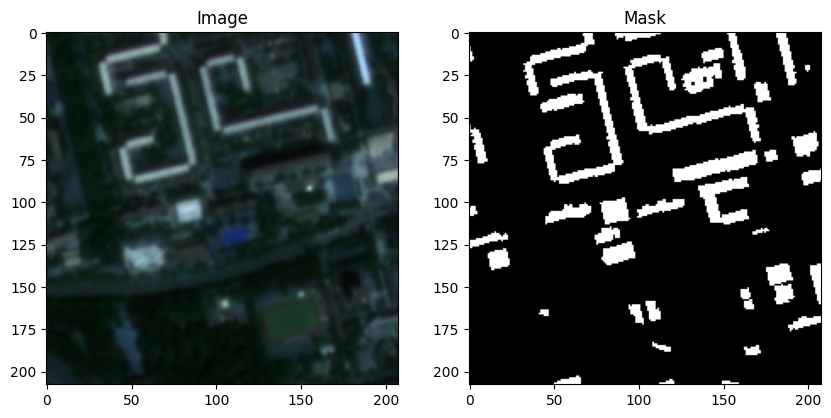

In [2]:
processed_zarr_name = region_filenames_json[regions[1]]['processed_zarr_name']
merged_xs = xr.open_zarr(processed_zarr_name, consolidated=True)

processed_zarr_name_clipped = processed_zarr_name.replace(".zarr", "_clipped.zarr")
merged_xs_clipped = xr.open_zarr(processed_zarr_name_clipped, consolidated=True)

input_xs= merged_xs_clipped


valid_planet_dates = (merged_xs['planetscope_sr_4band'].notnull().sum(dim=['x', 'y']) > 0).any(dim='channel').compute()
valid_planet_dates = merged_xs['time'].where(valid_planet_dates, drop=True).values

input_xs = input_xs[['buildings', 'planetscope_sr_4band']].sel(time=valid_planet_dates[0])


class PatchDataset(Dataset):
    def __init__(self, input_xs, patch_size=192, stride=192, min_valid_percent=90, transform=None):
        
        self.img_da = input_xs['planetscope_sr_4band'].sel(channel=['blue', 'green', 'red'])
        self.mask = input_xs['buildings'].values
        self.patch_size = patch_size
        self.stride = stride
        self.transform = transform

        # Pre-compute validity mask for image data
        print("Computing validity mask...")
        valid_mask = (~self.img_da.isnull()).all(dim='channel').values  # (H, W) boolean array
        
        # calc patch indices with validity filter
        self.patches = []
        H, W = self.mask.shape
        min_valid_pixels = int((patch_size * patch_size) * (min_valid_percent / 100))
        
        for y in range(0, H - patch_size + 1, stride):
            for x in range(0, W - patch_size + 1, stride):
                # count valid pixels in this patch
                valid_count = valid_mask[y:y+patch_size, x:x+patch_size].sum()
                
                if valid_count >= min_valid_pixels:
                    self.patches.append((y, x))
        
        print(f"Found {len(self.patches)} from a total of {((H - patch_size) // stride + 1) * ((W - patch_size) // stride + 1)} patches with at least {min_valid_percent}% valid data.")
        
        # convert to numpy
        self.img = self.img_da.values

    def __len__(self):
        return len(self.patches)

    def __getitem__(self, idx):
        y, x = self.patches[idx]
        img_patch = self.img[:, y:y+self.patch_size, x:x+self.patch_size].astype(np.float32)
        mask_patch = self.mask[y:y+self.patch_size, x:x+self.patch_size].astype(np.float32)
        
        # fill nans with -9999
        img_patch = np.nan_to_num(img_patch, nan=-9999)
        
        # normalize to [0,1]
        img_patch = (img_patch - img_patch.min()) / (img_patch.max() - img_patch.min() + 1e-6)
        
        # add channel dim to mask if needed
        mask_patch = np.expand_dims(mask_patch, axis=0)
        
        if self.transform:
            img_patch = self.transform(img_patch)
            mask_patch = self.transform(mask_patch)
        else:
            img_patch = torch.from_numpy(img_patch)
            mask_patch = torch.from_numpy(mask_patch)
        return img_patch, mask_patch


class InpaintControlDataset(Dataset):
    def __init__(self, patch_ds, make_hole='random_square', hole_size_px=64):
        self.patch_ds = patch_ds
        self.make_hole = make_hole
        self.hole_size_px = hole_size_px

    def __len__(self):
        return len(self.patch_ds)

    def __getitem__(self, idx):
        img, buildings = self.patch_ds[idx]  # img: [3,H,W] in [0,1]; buildings: [1,H,W] in [0,1]
        _, H, W = img.shape

        # --- create inpainting hole ---
        if self.make_hole == 'random_square':
            y0 = torch.randint(low=0, high=max(1, H - self.hole_size_px), size=(1,)).item()
            x0 = torch.randint(low=0, high=max(1, W - self.hole_size_px), size=(1,)).item()
            inpaint_mask = torch.zeros((1, H, W), dtype=img.dtype)
            inpaint_mask[:, y0:y0+self.hole_size_px, x0:x0+self.hole_size_px] = 1.0
        else:
            raise NotImplementedError

        # mask image
        masked_image = img * (1.0 - inpaint_mask)

        # --- control map (hint) ---
        # simplest: use buildings as 1-ch control (optionally stack more OSM layers later)
        control = buildings  # shape [1,H,W], normalize 0..1

        example = {
            "pixel_values": img,               # RGB target
            "control_map": control,            # ControlNet hint
            "mask": inpaint_mask,              # inpaint hole mask
            "masked_image": masked_image,      # context for inpainting
            "prompt_ids": torch.zeros(77, dtype=torch.long),  # empty prompt tokenized to CLIP length if using SD1.5
        }
        return example


resolution = 3 # resolution in meters
pixel_size = 650 # pixel size in meters
image_size = int(pixel_size / resolution)
# find image size as multiple of 16
if image_size % 16 != 0:
    image_size = int(image_size / 16) * 16
    print(f"Image size adjusted to {image_size} to be a multiple of 16")

# create dataset and dataloader
torch.manual_seed(42) # random seed for reproducible shuffling
patch_dataset = PatchDataset(input_xs, patch_size=image_size, stride=image_size, min_valid_percent=90)
patch_loader = DataLoader(patch_dataset, batch_size=8, shuffle=True)

inputs, masks = next(iter(patch_loader)) # get the first batch
print(inputs.shape, masks.shape)

train_ds = InpaintControlDataset(patch_dataset, hole_size_px=64)
train_dl = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=4)



# plot example mask and image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(inputs[0].permute(1, 2, 0).numpy())
ax[0].set_title('Image')
ax[1].imshow(masks[0].squeeze().numpy(), cmap='gray')
ax[1].set_title('Mask')
plt.show()

In [7]:
processed_zarr_name = region_filenames_json[regions[1]]['processed_zarr_name']
merged_xs = xr.open_zarr(processed_zarr_name, consolidated=True)
merged_xs

<xarray.Dataset> Size: 4GB
Dimensions:                          (y: 5580, x: 6211, time: 4, channel: 4)
Coordinates:
  * channel                          (channel) <U5 80B 'blue' 'green' ... 'nir'
    spatial_ref                      int64 8B ...
  * y                                (y) float64 45kB 5.699e+06 ... 5.682e+06
  * x                                (x) float64 50kB 3.078e+05 ... 3.264e+05
  * time                             (time) datetime64[ns] 32B 2019-06-24T10:...
Data variables:
    landuse                          (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    landsat_surface_temp_b10_masked  (time, y, x) float32 555MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    buildings_heights                (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    streets                          (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    ndvi                             (time, y, x) float32 555MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    buildings                        (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    buildings_service                (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    planetscope_sr_4band             (time, channel, y, x) float32 2GB dask.array<chunksize=(1, 4, 1024, 1024), meta=np.ndarray>
    streets_service                  (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    streets_surface                  (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>
    water                            (y, x) float32 139MB dask.array<chunksize=(1024, 1024), meta=np.ndarray>